In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools


In [3]:
torch.cuda.is_available()
torch.cuda.current_device()

0

In [4]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [5]:
train_data_list=[]
train_label_list=[]
for x,y in train_data:
    train_data_list.append(x)
    train_label_list.append(y)
    
test_data_list=[]
test_label_list=[]
for x,y in test_data:
    test_data_list.append(x)
    test_label_list.append(y)
    
train_data_tensor=torch.stack(train_data_list)
train_label_tensor=torch.tensor(train_label_list)
test_data_tensor=torch.stack(test_data_list)
test_label_tensor=torch.tensor(test_label_list)

print(train_data_tensor.size())
print(train_label_tensor.size())
print(test_data_tensor.size())
print(test_label_tensor.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [34]:
class Net(nn.Module):
    def __init__(self,feature_dim):
        super(Net, self).__init__()
        self.feature_dim=feature_dim
        self.final_weight_dim=feature_dim*10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, self.feature_dim)
        
        
#         self.prior_mu=torch.zeros(200, requires_grad=False).cuda()
#         self.prior_diag=torch.ones(200, requires_grad=False).cuda()
        
#         self.q_mu=torch.randn(200, requires_grad=True).cuda()
#         self.q_diag=torch.ones(200, requires_grad=True).cuda()

        self.prior_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=False)
        self.prior_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=False)
        
        self.q_mu=(torch.randn(200)*0.1).requires_grad_()
        self.q_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=True)
    
        params = list(self.parameters()) + [self.q_mu,self.q_diag]
        self.optimizer = optim.Adam(params, lr=0.0005)
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu, self.q_diag ], lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =torch.tanh(self.fc2(x))
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =  torch.tanh(self.fc2(x))
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.randn([100,self.final_weight_dim]).cuda()
            ##100 10 70
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,self.final_weight_dim)*eps+self.q_mu).view(100,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            
            prediction=(torch.mean(torch.softmax((inal_weight_samples@feature_of_data).permute(2, 0, 1),dim=-1),1).data.max(dim=1, keepdim=True)[1]).view(-1)
            return prediction
        
        
    def test(self,x,label):
        with torch.no_grad():
            eps=torch.randn([100,self.final_weight_dim]).cuda()
            ##100 10 70
            final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(100).view(100,self.final_weight_dim)*eps+self.q_mu.cuda()).view(100,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            print(final_weight_samples.size())
            print(x.size())
            print(feature_of_data.size())
            pred=(torch.mean(torch.softmax((final_weight_samples@feature_of_data.t()).permute(2, 0, 1),dim=-1),1).data.max(dim=1, keepdim=True)[1]).view(-1)
            print(pred.size())
            accuracy=(pred == label).sum().item()/label.size(0)
            return accuracy

        

        
        
    def predictive_distribution_entropy(self,x):
        with torch.no_grad():
            eps=torch.randn([100,self.final_weight_dim]).cuda()
            #eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(100).view(100,self.final_weight_dim)*eps+self.q_mu.cuda()).view(100,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            #100,10,20*20,70
            output_logit=final_weight_samples@feature_of_data.t()
            output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

            sample=output_dis.sample([100]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
            return entropy

#     def likelihood_eva(self,x, label, sample_num=100, if_online=False):
#         with torch.no_grad():
#             eps=torch.randn([sample_num,self.final_weight_dim]).cuda()
#             final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu.cuda()).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
#             feature_of_data=self.feature_forward(x)
#             output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)
#             nll_loss= F.nll_loss(output,label,reduction='sum')
#             neg_elbo=kl+nll_loss

#             return -neg_elbo
        
#     def likelihood_eva(self,x,label, sample_num=100, if_online=False):
#         with torch.no_grad():
#             eps=torch.randn([sample_num,self.final_weight_dim])
#             final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
#             feature_of_data=self.feature_forward(x)
#             print(final_weight_samples.size())
#             output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)

#             predicted=output.data.max(dim=1, keepdim=True)[1].view(-1)
#             accuracy=(predicted == label).sum().item()/label.size(0)

#             print(output.size())
#             nll_loss= F.nll_loss(output,label,reduction='sum')
#             if if_online:
#                 curr_prior_mu = self.q_mu.clone().detach()
#                 curr_prior_diag= self.q_diag.clone().detach()
#                 kl=KL_diag_gaussian(self.q_mu,self.q_diag,curr_prior_mu,curr_prior_diag)
#             else:
#                 kl=KL_diag_gaussian(self.q_mu,self.q_diag,self.prior_mu,self.prior_diag)
#             neg_elbo=kl+nll_loss

#             return -neg_elbo,accuracy
    
    def predictive_distribution_entropy_lower_bound(self,x, sample_num=100):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.final_weight_dim]).cuda()
            #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu.cuda()).view(sample_num,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)

            output_logit=(final_weight_samples@feature_of_data.t()).permute(2, 0, 1)
            y_samples=sample_from_batch_categorical(output_logit).view(-1)
#             print(y_samples.size())
            output=torch.mean(F.log_softmax(output_logit,dim=-1),1)
#             print(output.size())
            output_repeat=output.repeat(1,sample_num).view(-1,10)
            nll= F.nll_loss(output_repeat,y_samples,reduction='mean')
            kl=KL_diag_gaussian(self.q_mu.cuda(),self.q_diag.cuda(),self.prior_mu.cuda(),self.prior_diag.cuda())
            return nll+kl
    
    def predictive_distribution_entropy_2(self,x, sample_num=100):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.final_weight_dim]).cuda()
            #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu.cuda()).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]

            output_logit=final_weight_samples@feature_of_data
            output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

            eps=torch.randn([sample_num,self.final_weight_dim]).cuda()
            #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu.cuda()).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=final_weight_samples@feature_of_data
            output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)

            sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
            return entropy
        
        
    def predictive_distribution_entropy_batch(self,x, sample_num=100):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.final_weight_dim]).cuda()
            #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu.cuda()).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
#             print(final_weight_samples.size())
            output_logit=(final_weight_samples@feature_of_data.t()).permute(2,0,1)
            log_prob=F.log_softmax(output_logit,dim=-1)
            entropy_lower_bound=-torch.mean(torch.sum(log_prob*torch.exp(log_prob),dim=2),dim=1)
#             print(entropy_lower_bound.size())
            
            return entropy_lower_bound
            
            
            
            
            
#             output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

#             eps=torch.randn([sample_num,self.final_weight_dim]).cuda()
#             #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
#             final_weight_samples=(torch.sqrt(self.q_diag.cuda()).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu.cuda()).view(sample_num,20,10).permute(0, 2, 1)
#             feature_of_data=self.feature_forward(x)
#             output_logit=feature_of_data@final_weight_samples
#             output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)

#             sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
#             entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
#             return entropy
    

    
    
    def online_train(self,x,label,samlpe_num=100):
        train_losses = []
        total_size=x.size(0)
        curr_prior_mu = self.q_mu.clone().detach()
        curr_prior_diag= self.q_diag.clone().detach()
        correct_flag=0

        while correct_flag<5:
            
#             lr = 0.01 * (0.1 ** (it // 2000))
#             for param_group in self.final_optimizer.param_groups:
#                 param_group['lr'] = lr
        
            self.final_optimizer.zero_grad()
            eps=torch.randn([samlpe_num,self.final_weight_dim])
            #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(samlpe_num).view(samlpe_num,self.final_weight_dim)*eps+self.q_mu).view(samlpe_num,self.feature_dim,10).permute(0, 2, 1)

    #         eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
    #         final_weight_samples= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            feature_of_data=self.feature_forward(x)
    #         print(feature_of_data.size())
            output=torch.mean(F.log_softmax((final_weight_samples@feature_of_data.t()).permute(0, 2, 1),dim=-1),0)
            
            nll_loss= F.nll_loss(output,label,reduction='sum')
            kl=KL_diag_gaussian(self.q_mu,self.q_diag,curr_prior_mu,curr_prior_diag)
            neg_elbo=kl+nll_loss
            neg_elbo.backward()
            self.final_optimizer.step()
            train_losses.append(neg_elbo.item())
            
            
            if output.data.max(dim=1, keepdim=True)[1].item()==label.item():
                correct_flag+=1
            else:
                correct_flag=0
        print(output.data.max(dim=1, keepdim=True)[1].item())
        plt.plot(train_losses)
        plt.show()
        
        
    
    def train(self,x,label):
        train_losses = []
        if x.size(0)<100:
            batch_size=x.size(0)
            iteration=1
        else:
            batch_size=100
            iteration=int(x.size(0)/batch_size)
        for epoch in range(0,3000):
            for it in range(0,int(x.size(0)/batch_size)+1):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()

    #             conditional_loss=0
    #             for i in range(0,10):
                eps=torch.randn([self.final_weight_dim]).cuda()
                final_weight_sample= (self.q_mu.cuda()+eps*torch.sqrt(self.q_diag.cuda())).view(self.feature_dim,10)
                output = self.forward(x[index],final_weight_sample)
                nll_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
                kl=KL_diag_gaussian(self.q_mu.cuda(),self.q_diag.cuda(),self.prior_mu.cuda(),self.prior_diag.cuda())
                neg_elbo=kl+nll_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        
        
#     def test(self):
#         correct=0
#         for data, target in test_loader:
#             pred = self.predict(data)
#             correct += pred.eq(target.data.view_as(pred)).sum()
#             correct_ratio= float(correct)/len(test_loader.dataset)
#         return correct_ratio
    

big_epoch: 0 start training...
train_data_size 10


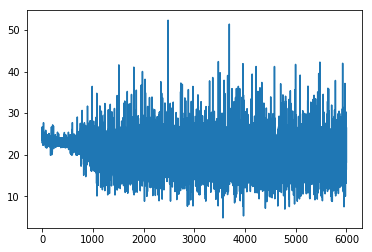

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 0 test_accuracy 0.3072
big_epoch: 1 start training...
train_data_size 20


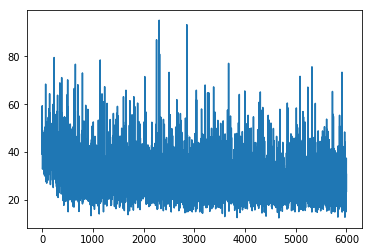

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 1 test_accuracy 0.4037
big_epoch: 2 start training...
train_data_size 30


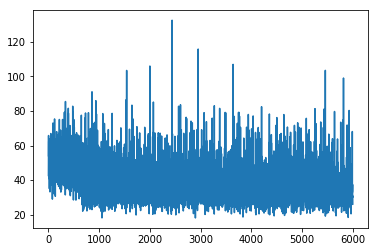

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 2 test_accuracy 0.4955
big_epoch: 3 start training...
train_data_size 40


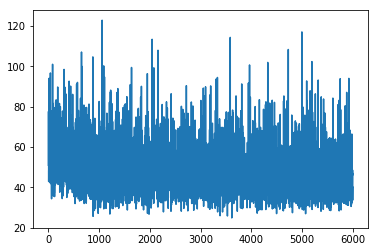

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 3 test_accuracy 0.5657
big_epoch: 4 start training...
train_data_size 50


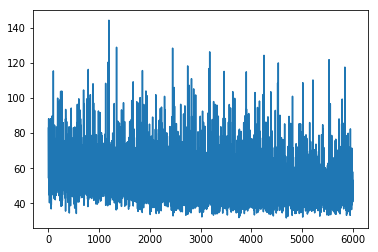

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 4 test_accuracy 0.6706
big_epoch: 5 start training...
train_data_size 60


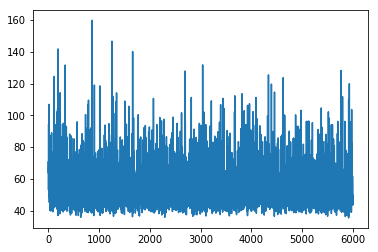

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 5 test_accuracy 0.7
big_epoch: 6 start training...
train_data_size 70


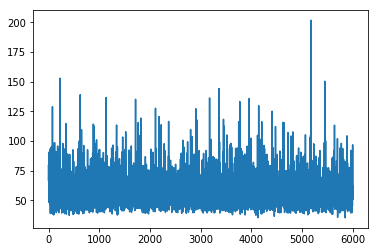

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 6 test_accuracy 0.7225
big_epoch: 7 start training...
train_data_size 80


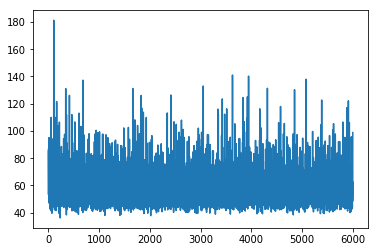

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 7 test_accuracy 0.7384
big_epoch: 8 start training...
train_data_size 90


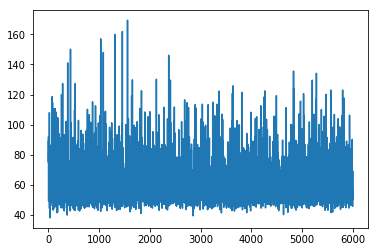

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 8 test_accuracy 0.7467
big_epoch: 9 start training...
train_data_size 100


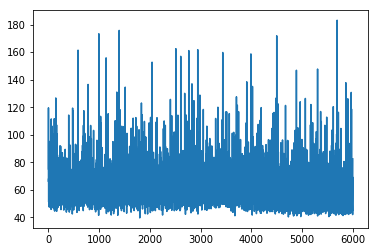

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 9 test_accuracy 0.8285
big_epoch: 10 start training...
train_data_size 110


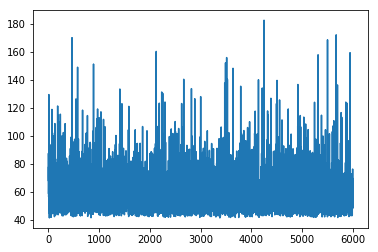

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 10 test_accuracy 0.8448
big_epoch: 11 start training...
train_data_size 120


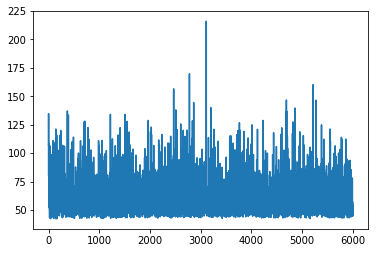

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 11 test_accuracy 0.8699
big_epoch: 12 start training...
train_data_size 130


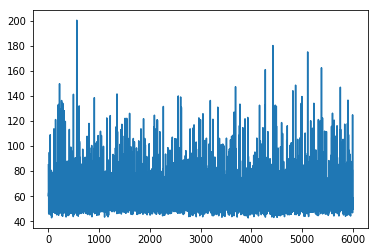

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 12 test_accuracy 0.8627
big_epoch: 13 start training...
train_data_size 140


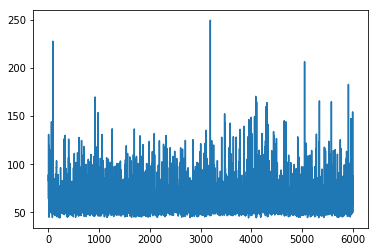

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 13 test_accuracy 0.8763
big_epoch: 14 start training...
train_data_size 150


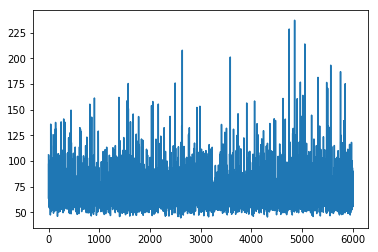

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 14 test_accuracy 0.8671
big_epoch: 15 start training...
train_data_size 160


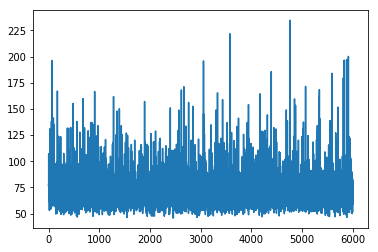

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 15 test_accuracy 0.8607
big_epoch: 16 start training...
train_data_size 170


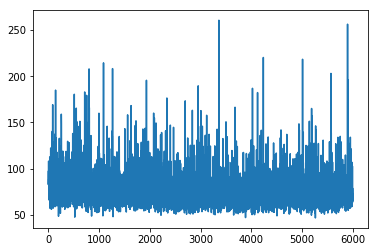

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 16 test_accuracy 0.8706
big_epoch: 17 start training...
train_data_size 180


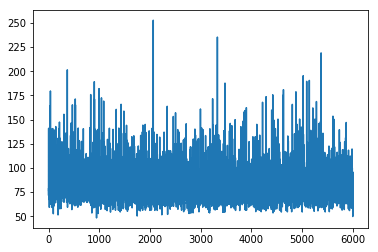

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 17 test_accuracy 0.8761
big_epoch: 18 start training...
train_data_size 190


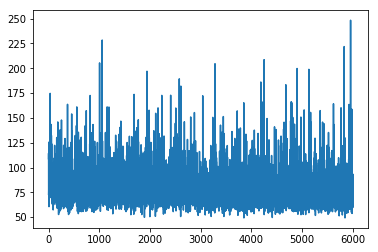

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 18 test_accuracy 0.864
big_epoch: 19 start training...
train_data_size 200


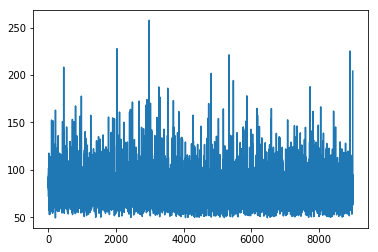

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 19 test_accuracy 0.8948
big_epoch: 20 start training...
train_data_size 210


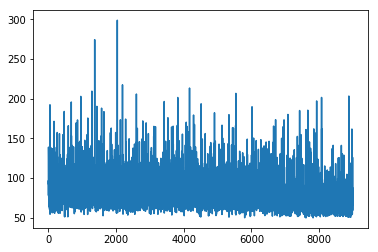

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 20 test_accuracy 0.8879
big_epoch: 21 start training...
train_data_size 220


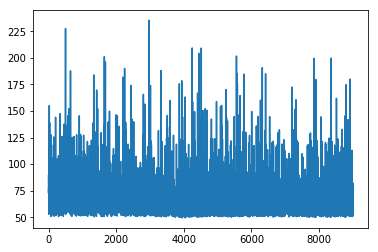

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 21 test_accuracy 0.8935
big_epoch: 22 start training...
train_data_size 230


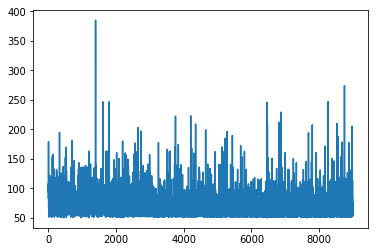

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 22 test_accuracy 0.905
big_epoch: 23 start training...
train_data_size 240


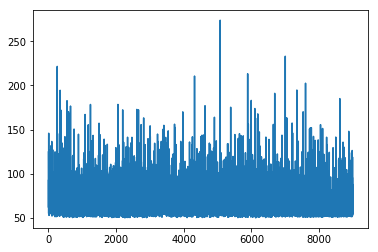

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 23 test_accuracy 0.9063
big_epoch: 24 start training...
train_data_size 250


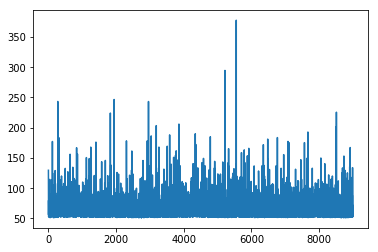

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 24 test_accuracy 0.9162
big_epoch: 25 start training...
train_data_size 260


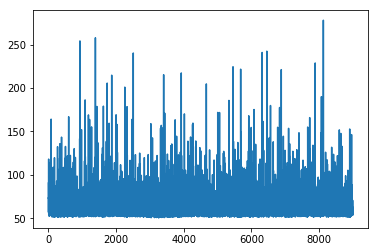

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 25 test_accuracy 0.9216
big_epoch: 26 start training...
train_data_size 270


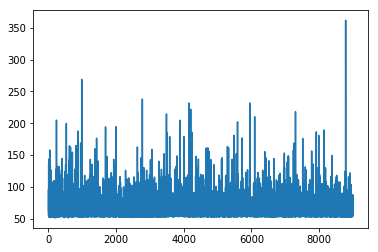

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 26 test_accuracy 0.9022
big_epoch: 27 start training...
train_data_size 280


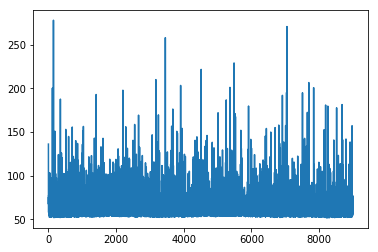

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 27 test_accuracy 0.9025
big_epoch: 28 start training...
train_data_size 290


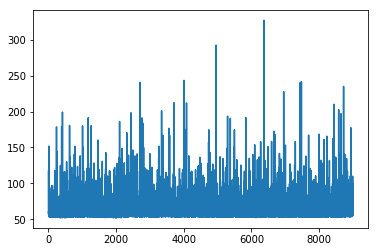

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 28 test_accuracy 0.9165
big_epoch: 29 start training...
train_data_size 300


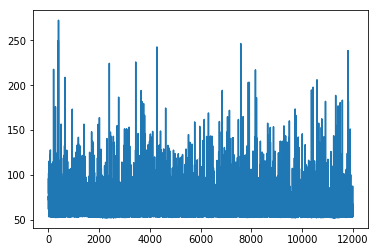

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 29 test_accuracy 0.9137
big_epoch: 30 start training...
train_data_size 310


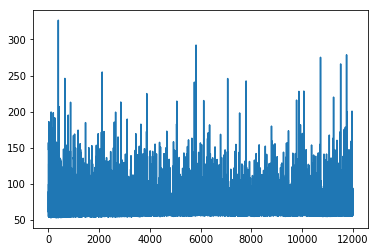

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 30 test_accuracy 0.9026
big_epoch: 31 start training...
train_data_size 320


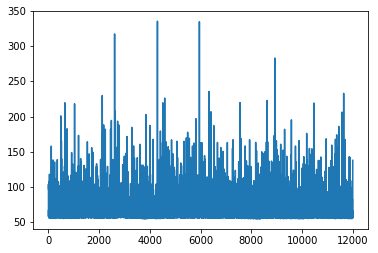

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 31 test_accuracy 0.9081
big_epoch: 32 start training...
train_data_size 330


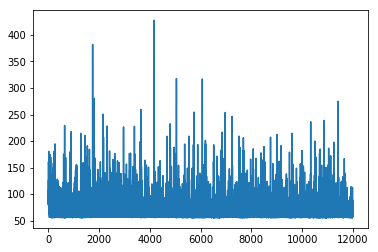

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 32 test_accuracy 0.904
big_epoch: 33 start training...
train_data_size 340


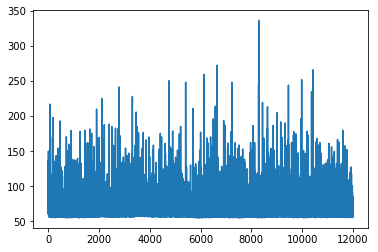

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 33 test_accuracy 0.9055
big_epoch: 34 start training...
train_data_size 350


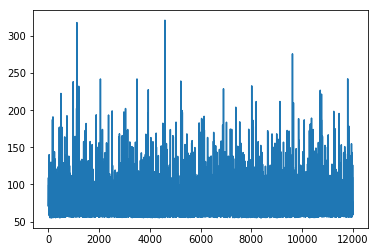

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 34 test_accuracy 0.9066
big_epoch: 35 start training...
train_data_size 360


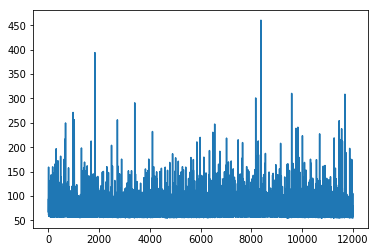

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 35 test_accuracy 0.9075
big_epoch: 36 start training...
train_data_size 370


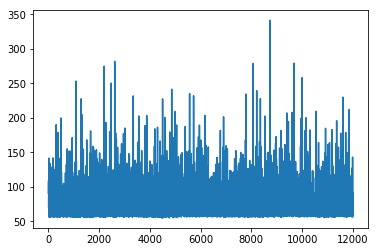

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 36 test_accuracy 0.9064
big_epoch: 37 start training...
train_data_size 380


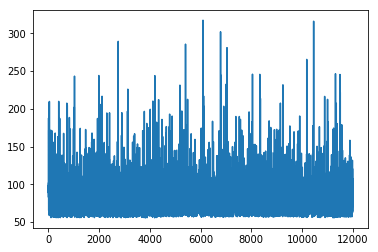

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 37 test_accuracy 0.9043
big_epoch: 38 start training...
train_data_size 390


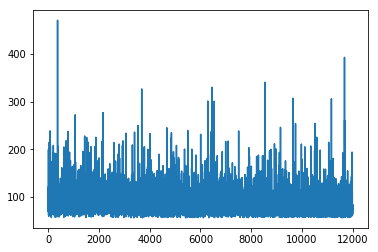

torch.Size([100, 10, 20])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 20])
torch.Size([10000])
epoch: 38 test_accuracy 0.9073
big_epoch: 39 start training...
train_data_size 400


In [ ]:
nn_tanh = Net(feature_dim=20).cuda()
init_train_data=train_data_tensor[0:10].cuda()
init_train_label=train_label_tensor[0:10].cuda()
accuracy_list=[]
for epoch in range(0,100):
    print('big_epoch:', epoch, 'start training...')
    print('train_data_size',init_train_label.size(0))
    nn_tanh.train(init_train_data,init_train_label)
    
    accuracy=nn_tanh.test(test_data_tensor.cuda(),test_label_tensor.cuda())
    accuracy_list.append(accuracy)
    print('epoch:', epoch, 'test_accuracy', accuracy)
#     plt.title('test_accuracy')
#     plt.plot(accuracy_list)
#     plt.show()
    ### active part
#     print('epoch:', epoch, 'start active learning...')


    for i in range(0,10):
        active_batch_data=train_data_tensor[i*6000:(i+1)*6000].cuda()
        entropy_list=nn_tanh.predictive_distribution_entropy_batch(active_batch_data)
        _, index = entropy_list.max(0)
        init_train_data=torch.cat((init_train_data,active_batch_data[index].view(1,1,28,28).cuda()),0)
        init_train_label=torch.cat((init_train_label,train_label_tensor[index+i*6000].view(-1).cuda()),0)
        
#     for i in range(0,10):
#         active_batch_data=train_data_tensor[i*6000:(i+1)*6000].cuda()
#         entropy_list=[]
#         for index in range(i*6000,(i+1)*6000):
#             entropy=nn_tanh.predictive_distribution_entropy_2(train_data_tensor[index].cuda())
#             entropy_list.append(entropy)

#         index_max = np.argmax(entropy_list)
#         init_train_data=torch.cat((init_train_data,active_batch_data[index_max].view(1,1,28,28).cuda()),0)
#         init_train_label=torch.cat((init_train_label,train_label_tensor[index_max+i*6000].view(-1).cuda()),0)
        
plt.title('test_accuracy')
plt.plot(accuracy_list)
plt.show()
print(accuracy_list)

In [ ]:
# train_dict={}
# for (data, target) in train_data:
#     if  target not in train_dict:
#         train_dict[ target]=[]
#         train_dict[ target].append(data)
#     else:
#         train_dict[ target].append(data)
        
# initial_train_data=[]
# initial_train_label=[]
# for i in range(7):
#     for j in range(0,10):
#         initial_train_data.append(train_dict[i][j])
#         initial_train_label.append(i)
    
# print(initial_train_label)


# initial_train_data_tensor=torch.stack(initial_train_data)
# initial_train_label_tensor=torch.tensor(initial_train_label)
# train_x=torch.stack([data for (data, target) in train_data])
# train_label=torch.tensor([target for (data, target) in train_data])
# print(initial_train_data_tensor.size())
# print(initial_train_label_tensor.size())

In [ ]:
# active_bnn = Net(feature_dim=20).cuda()
# active_bnn.train(initial_train_data_tensor.cuda(),initial_train_label_tensor.cuda())

In [ ]:
# # print(active_bnn.test_prediction(initial_train_data_tensor))
# # # print(active_bnn.predict(initial_train_data_tensor))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[6][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[8][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[8][21].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[1][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[1][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[0][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[4][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[4][16].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[4][15].cuda()))
# print('yo')
# # print(active_bnn.predictive_distribution_entropy(train_dict[6][20].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[8][20].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[8][21].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[1][20].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[1][1].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[0][1].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[4][1].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[4][16].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[4][15].cuda()))

# print('yo')
# print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15].cuda()))
